In [1]:
import numpy as np
#import tensorflow as tf
from matplotlib import pyplot as plt
import glob
import random
from sklearn.preprocessing import normalize


In [2]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

def norm_twoarr(arr1,arr2):
    min1 = np.min([arr1,arr2])
    max1 = np.max([arr1,arr2])
    
    arr1new = (arr1 - min1)/(max1 - min1)
    arr2new = (arr2 - min1)/(max1 - min1)
    
    return arr1new, arr2new

## Eta 160

In [10]:
path3="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Eventcode/new_profile_singlePHS_projection/samples/"
hs_profile = np.load(path3+"Nside1024_singleHS_profile.npy")

# h(x) -> h(k)
h_frame = np.zeros( ( 90  ,  90 )) # Frame with zeros
h_frame[0:len(hs_profile),0:len(hs_profile)]+= hs_profile
np_rfft_hk=np.fft.rfft2(h_frame)


In [11]:
path = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'
#tot = np.load(path+"1PHS6Events_Nside2048_d0_d80_BKG_"+str(0)+".npy")

qlbkgs = np.empty((0, 90, 90))
for evnts in range(1):
    temp = np.load(path+"quicklens_90x90_uncuts/500_events_90Sqr_lensed_uncutBackgroundlmax3500_"+str(evnts)+".npy")

    qlbkgs = np.concatenate((qlbkgs,temp))

In [12]:
qlbkgs_power = np.load(path+"quicklens_90x90_uncuts/500_events_90Sqr_lensed_uncutBackgroundlmax3500_1.npy")

In [13]:
# FFT average of multiple Backgrounds
fft_power = np.zeros((np_rfft_hk.shape[0],np_rfft_hk.shape[1]))
print((np_rfft_hk.shape[0],np_rfft_hk.shape[1]))
#fft_power = np.zeros((420,420))
for evnt in range(len(qlbkgs_power)):
    temp = qlbkgs_power[evnt]
    tempfft = np.fft.rfft2(temp)
    temppower = tempfft*np.conj(tempfft)
    fft_power = fft_power + temppower
    if not (evnt+1) % 500:
        print(str(evnt+1))
        
fft_power = np.real(fft_power)/len(qlbkgs)

(90, 46)
500


## Event by event analysis (Maximum value based)

In [16]:
tot_evnt = 500
rescale_val = 2
num_select = 1

selected_evnts = []

for tries in range(tot_evnt):
    gen_list = np.random.choice(range(0,150), num_select, replace = False).reshape(-1,num_select)
    selected_evnts.append(gen_list[0])

selected_evnts = np.array(selected_evnts)

0.004516707744604083
1.0


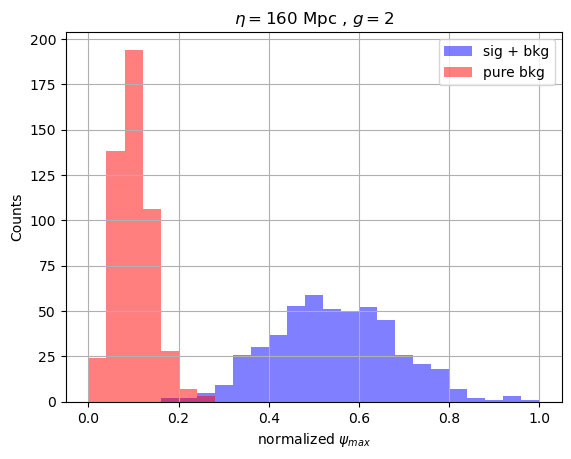

In [17]:
# FFT on planted signals
pathsig = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'

PHSsignals = []
for batch in range(1,4):
    temp = np.load(pathsig+"PHS_signal/500_PHS_g1_Sig_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(tot_evnt):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)

PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)

qlBkpSig = qlbkgs[:tot_evnt]+PHSsig


qlBkpSigfilt_max = []
qlBkgfilt_max = []

for evnts in range(tot_evnt):
    qltempfftbkg = np.fft.rfft2(qlbkgs[evnts])
    qltempfftspb = np.fft.rfft2(qlBkpSig[evnts])
    
    qltempfftbkg[0,0]=0
    qltempfftspb[0,0]=0
    
    fft_power[fft_power<10**-20]=10**20
    qltempbkgfiltered = np.fft.irfft2(qltempfftbkg  * np_rfft_hk/fft_power)
    qltempspbfiltered = np.fft.irfft2(qltempfftspb  * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #print(np.average(qltempbkgfiltered))
    #print(np.average(qltempspbfiltered))
    
    qlBkgfilt_max.append(np.max(qltempbkgfiltered))
    qlBkpSigfilt_max.append(np.max(qltempspbfiltered))
    


qlBkgfilt_max = np.array(qlBkgfilt_max)
qlBkpSigfilt_max = np.array(qlBkpSigfilt_max)

print(qlBkpSigfilt_max.max())

qlBkgfilt_max, qlBkpSigfilt_max = norm_twoarr(qlBkgfilt_max,qlBkpSigfilt_max)

print(qlBkpSigfilt_max.max())
binsabs = np.arange(0,1.02,0.04)

binsmid=((binsabs[1:]+binsabs[:-1])/2)

#thres = 37
#n1max = 45

n2, bins2, patches2 = plt.hist(qlBkpSigfilt_max,binsabs,alpha = 0.5,color = 'blue',label = "sig + bkg",density=False)

n1, bins1, patches1 = plt.hist(qlBkgfilt_max,binsabs,alpha = 0.5,color = 'red',label = "pure bkg",density=False)

#plt.plot(binsmid,gauss(binsmid,*params),color='red',lw=2,label='model')

plt.legend()

#plt.ylim(0, 10**3)
plt.xlabel('normalized $\psi_{max}$')
plt.ylabel('Counts')
plt.grid(True)
plt.title(f'$\eta = 160$ Mpc , $g = {rescale_val}$')
plt.savefig(f"MF90sq_result/eta160_g{rescale_val}_dist.pdf")

In [18]:
# Range cuts 
# g = 3, thre = 5
# g = 2, thre = 8
# g = 1, thre = 17
threshold = 5

In [51]:
n1[threshold:]

array([77., 76., 32., 22.,  9.,  5.,  5.,  1.,  2.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [52]:
n2[threshold:]

array([66., 63., 50., 44., 42., 29., 23., 22., 16., 14., 11.,  3.,  5.,
        1.,  1.,  2.,  2.,  1.,  0.,  1.])

In [53]:
print(f'Fake rate(%) = {100*n1[threshold:].sum()/tot_evnt}')
print(f'Signal efficiency(%) = {100*n2[threshold:].sum()/tot_evnt}')

Fake rate(%) = 45.8
Signal efficiency(%) = 79.2


In [54]:
len(qlBkpSigfilt_max[qlBkpSigfilt_max>qlBkgfilt_max.max()])/tot_evnt*100

8.200000000000001

In [55]:
np.save(f"MF90sq_result/eta160_g{rescale_val}_sigpbkg",qlBkpSigfilt_max)
np.save(f"MF90sq_result/eta160_g{rescale_val}_bkg",qlBkgfilt_max)

## Eta 100

In [3]:
path3="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Eventcode/new_profile_singlePHS_projection/samples/"
hs_profile = np.load(path3+"Nside1024_singleHS_eta100_profile.npy")

# h(x) -> h(k)
h_frame = np.zeros( ( 90  ,  90 )) # Frame with zeros
h_frame[0:len(hs_profile),0:len(hs_profile)]+= hs_profile
np_rfft_hk=np.fft.rfft2(h_frame)

In [4]:
path = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'
#tot = np.load(path+"1PHS6Events_Nside2048_d0_d80_BKG_"+str(0)+".npy")

qlbkgs = np.empty((0, 90, 90))
for evnts in range(1):
    temp = np.load(path+"quicklens_90x90_uncuts/500_events_90Sqr_lensed_uncutBackgroundlmax3500_"+str(evnts)+".npy")

    qlbkgs = np.concatenate((qlbkgs,temp))

In [5]:
qlbkgs_power = np.load(path+"quicklens_90x90_uncuts/500_events_90Sqr_lensed_uncutBackgroundlmax3500_1.npy")

In [6]:
# FFT average of multiple Backgrounds
fft_power = np.zeros((np_rfft_hk.shape[0],np_rfft_hk.shape[1]))
print((np_rfft_hk.shape[0],np_rfft_hk.shape[1]))
#fft_power = np.zeros((420,420))
for evnt in range(len(qlbkgs_power)):
    temp = qlbkgs_power[evnt]
    tempfft = np.fft.rfft2(temp)
    temppower = tempfft*np.conj(tempfft)
    fft_power = fft_power + temppower
    if not (evnt+1) % 500:
        print(str(evnt+1))
        
fft_power = np.real(fft_power)/len(qlbkgs)

(90, 46)
500


## Event by event analysis (Maximum value based)

In [7]:
tot_evnt = 500
rescale_val = 2
num_select = 1

selected_evnts = []

for tries in range(tot_evnt):
    gen_list = np.random.choice(range(0,150), num_select, replace = False).reshape(-1,num_select)
    selected_evnts.append(gen_list[0])

selected_evnts = np.array(selected_evnts)

0.002407384094152086
1.0


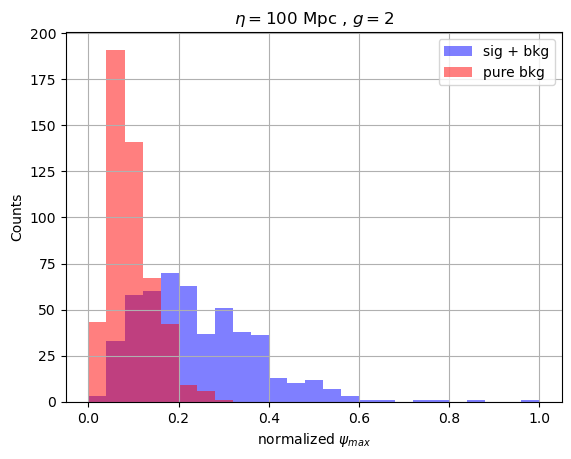

In [9]:
# FFT on planted signals
pathsig = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'

PHSsignals = []
for batch in range(1,4):
    temp = np.load(pathsig+"PHS_signal/500_eta100PHS_g1_Sig_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

#selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(tot_evnt):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)

PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)

qlBkpSig = qlbkgs[:tot_evnt]+PHSsig


qlBkpSigfilt_max = []
qlBkgfilt_max = []

for evnts in range(tot_evnt):
    qltempfftbkg = np.fft.rfft2(qlbkgs[evnts])
    qltempfftspb = np.fft.rfft2(qlBkpSig[evnts])
    
    qltempfftbkg[0,0]=0
    qltempfftspb[0,0]=0
    
    fft_power[fft_power<10**-20]=10**20
    qltempbkgfiltered = np.fft.irfft2(qltempfftbkg  * np_rfft_hk/fft_power)
    qltempspbfiltered = np.fft.irfft2(qltempfftspb  * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #print(np.average(qltempbkgfiltered))
    #print(np.average(qltempspbfiltered))
    
    qlBkgfilt_max.append(np.max(qltempbkgfiltered))
    qlBkpSigfilt_max.append(np.max(qltempspbfiltered))
    


qlBkgfilt_max = np.array(qlBkgfilt_max)
qlBkpSigfilt_max = np.array(qlBkpSigfilt_max)

print(qlBkpSigfilt_max.max())

qlBkgfilt_max, qlBkpSigfilt_max = norm_twoarr(qlBkgfilt_max,qlBkpSigfilt_max)

print(qlBkpSigfilt_max.max())
binsabs = np.arange(0,1.02,0.04)

binsmid=((binsabs[1:]+binsabs[:-1])/2)

#thres = 37
#n1max = 45

n2, bins2, patches2 = plt.hist(qlBkpSigfilt_max,binsabs,alpha = 0.5,color = 'blue',label = "sig + bkg",density=False)

n1, bins1, patches1 = plt.hist(qlBkgfilt_max,binsabs,alpha = 0.5,color = 'red',label = "pure bkg",density=False)

#plt.plot(binsmid,gauss(binsmid,*params),color='red',lw=2,label='model')

plt.legend()

#plt.ylim(0, 10**3)
plt.xlabel('normalized $\psi_{max}$')
plt.ylabel('Counts')
plt.grid(True)
plt.title(f'$\eta = 100$ Mpc , $g = {rescale_val}$')
plt.savefig(f"MF90sq_result/eta100_g{rescale_val}_dist.pdf")

In [78]:
# Range cuts 
# g = 3, thre = 4
# g = 2, thre = 7
# g = 1, thre = 17
threshold = 10

In [79]:
n1[threshold:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [80]:
n2[threshold:]

array([21., 14.,  9.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.])

In [81]:
print(f'Fake rate(%) = {100*n1[threshold:].sum()/tot_evnt}')
print(f'Signal efficiency(%) = {100*n2[threshold:].sum()/tot_evnt}')

Fake rate(%) = 0.0
Signal efficiency(%) = 10.0


In [82]:
len(qlBkpSigfilt_max[qlBkpSigfilt_max>qlBkgfilt_max.max()])/tot_evnt*100

93.8

In [83]:
np.save(f"MF90sq_result/eta100_g{rescale_val}_sigpbkg",qlBkpSigfilt_max)
np.save(f"MF90sq_result/eta100_g{rescale_val}_bkg",qlBkgfilt_max)

## Eta 50

In [84]:
path3="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Eventcode/new_profile_singlePHS_projection/samples/"
hs_profile = np.load(path3+"Nside1024_singleHS_eta50_profile.npy")

# h(x) -> h(k)
h_frame = np.zeros( ( 90  ,  90 )) # Frame with zeros
h_frame[0:len(hs_profile),0:len(hs_profile)]+= hs_profile
np_rfft_hk=np.fft.rfft2(h_frame)


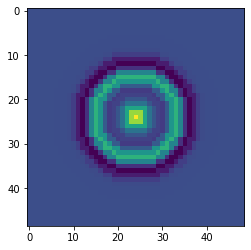

In [85]:
plt.imshow(hs_profile)

In [86]:
path = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'
#tot = np.load(path+"1PHS6Events_Nside2048_d0_d80_BKG_"+str(0)+".npy")

qlbkgs = np.empty((0, 90, 90))
for evnts in range(1):
    temp = np.load(path+"quicklens_90x90_uncuts/500_events_90Sqr_lensed_uncutBackgroundlmax3500_"+str(evnts)+".npy")

    qlbkgs = np.concatenate((qlbkgs,temp))

In [87]:
qlbkgs_power = np.load(path+"quicklens_90x90_uncuts/500_events_90Sqr_lensed_uncutBackgroundlmax3500_1.npy")

In [88]:
# FFT average of multiple Backgrounds
fft_power = np.zeros((np_rfft_hk.shape[0],np_rfft_hk.shape[1]))
print((np_rfft_hk.shape[0],np_rfft_hk.shape[1]))
#fft_power = np.zeros((420,420))
for evnt in range(len(qlbkgs_power)):
    temp = qlbkgs_power[evnt]
    tempfft = np.fft.rfft2(temp)
    temppower = tempfft*np.conj(tempfft)
    fft_power = fft_power + temppower
    if not (evnt+1) % 500:
        print(str(evnt+1))
        
fft_power = np.real(fft_power)/len(qlbkgs)

(90, 46)
500


## Event by event analysis (Maximum value based)

In [121]:
tot_evnt = 500
rescale_val = 1
num_select = 1

selected_evnts = []

for tries in range(tot_evnt):
    gen_list = np.random.choice(range(0,150), num_select, replace = False).reshape(-1,num_select)
    selected_evnts.append(gen_list[0])

selected_evnts = np.array(selected_evnts)

0.0008597218804584467
0.9918145779663856


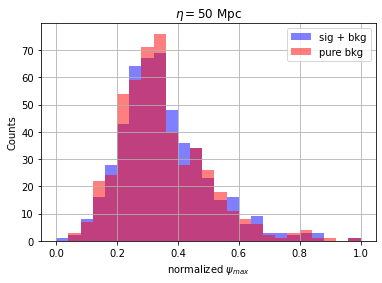

In [122]:
# FFT on planted signals
pathsig = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'

PHSsignals = []
for batch in range(1,4):
    temp = np.load(pathsig+"PHS_signal/500_eta50PHS_g1_Sig_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

#selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(tot_evnt):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)

PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)

qlBkpSig = qlbkgs[:tot_evnt]+PHSsig


qlBkpSigfilt_max = []
qlBkgfilt_max = []

for evnts in range(tot_evnt):
    qltempfftbkg = np.fft.rfft2(qlbkgs[evnts])
    qltempfftspb = np.fft.rfft2(qlBkpSig[evnts])
    
    qltempfftbkg[0,0]=0
    qltempfftspb[0,0]=0
    
    fft_power[fft_power<10**-20]=10**20
    qltempbkgfiltered = np.fft.irfft2(qltempfftbkg  * np_rfft_hk/fft_power)
    qltempspbfiltered = np.fft.irfft2(qltempfftspb  * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #print(np.average(qltempbkgfiltered))
    #print(np.average(qltempspbfiltered))
    
    qlBkgfilt_max.append(np.max(qltempbkgfiltered))
    qlBkpSigfilt_max.append(np.max(qltempspbfiltered))
    


qlBkgfilt_max = np.array(qlBkgfilt_max)
qlBkpSigfilt_max = np.array(qlBkpSigfilt_max)

print(qlBkpSigfilt_max.max())

qlBkgfilt_max, qlBkpSigfilt_max = norm_twoarr(qlBkgfilt_max,qlBkpSigfilt_max)

print(qlBkpSigfilt_max.max())
binsabs = np.arange(0,1.02,0.04)

binsmid=((binsabs[1:]+binsabs[:-1])/2)

#thres = 37
#n1max = 45

n2, bins2, patches2 = plt.hist(qlBkpSigfilt_max,binsabs,alpha = 0.5,color = 'blue',label = "sig + bkg",density=False)

n1, bins1, patches1 = plt.hist(qlBkgfilt_max,binsabs,alpha = 0.5,color = 'red',label = "pure bkg",density=False)

#plt.plot(binsmid,gauss(binsmid,*params),color='red',lw=2,label='model')

plt.legend()

plt.xlabel('normalized $\psi_{max}$')
plt.ylabel('Counts')
plt.grid(True)
plt.title('$\eta = 50$ Mpc')
plt.savefig(f"MF90sq_result/eta50_g{rescale_val}_dist.pdf")

In [123]:
# Range cuts 
# g = 3, thre = 6
# g = 2, thre = 8
# g = 1, thre = 17
threshold = 10

In [124]:
n1[threshold:]

array([28., 34., 26., 18., 11.,  8.,  6.,  2.,  1.,  3.,  4.,  1.,  1.,
        0.,  1.])

In [125]:
n2[threshold:]

array([36., 34., 23., 15., 16.,  6.,  9.,  3.,  3.,  2.,  3.,  3.,  0.,
        0.,  1.])

In [126]:
print(f'Fake rate(%) = {100*n1[threshold:].sum()/tot_evnt}')
print(f'Signal efficiency(%) = {100*n2[threshold:].sum()/tot_evnt}')

Fake rate(%) = 28.8
Signal efficiency(%) = 30.8


In [127]:
len(qlBkpSigfilt_max[qlBkpSigfilt_max>qlBkgfilt_max.max()])/tot_evnt*100

0.0

In [128]:
np.save(f"MF90sq_result/eta50_g{rescale_val}_sigpbkg",qlBkpSigfilt_max)
np.save(f"MF90sq_result/eta50_g{rescale_val}_bkg",qlBkgfilt_max)

In [230]:
'''num_select = 25
selected_evnts = []

for tries in range(500):
    gen_list = np.random.choice(range(0,150), num_select, replace = False).reshape(-1,num_select)
    selected_evnts.append(gen_list[0])

selected_evnts = np.array(selected_evnts)
np.save("selected_rand_list_"+str(num_select)+"PHS",selected_evnts)
'''

'num_select = 25\nselected_evnts = []\n\nfor tries in range(500):\n    gen_list = np.random.choice(range(0,150), num_select, replace = False).reshape(-1,num_select)\n    selected_evnts.append(gen_list[0])\n\nselected_evnts = np.array(selected_evnts)\nnp.save("selected_rand_list_"+str(num_select)+"PHS",selected_evnts)\n'

## Event by event analysis (average value based) (Trashed)

In [ ]:
'''tot_evnt = 500
rescale_val = 2
num_select = 1'''

In [ ]:
'''# FFT on planted signals
pathsig = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/'

PHSsignals = []
for batch in range(1,4):
    temp = np.load(pathsig+"PHS_signal/500_PHS_g1_Sig_"+str(batch)+".npy")
    for evnt in range(len(temp)):
        PHSsignals.append(temp[evnt])

PHSsignals = np.array(PHSsignals)

selected_evnts = np.load('selected_rand_list_'+str(num_select)+'PHS.npy')

PHSsig = []
PHSsig_loc = []
for events in range(tot_evnt):
    temp = 0
    temp_loc = []
    for num in range(num_select):
        temp += PHSsignals[selected_evnts[events,num]]
        test = PHSsignals[selected_evnts[events,num]]
        test_loc = np.where((test==test.max()))
        test_locx = int(np.mean(test_loc[0]))
        test_locy = int(np.mean(test_loc[1]))
        temp_loc.append([test_locx,test_locy])
    PHSsig.append(temp)
    PHSsig_loc.append(temp_loc)

PHSsig = rescale_val * np.array(PHSsig)
PHSsig_loc = np.array(PHSsig_loc)

qlBkpSig = qlbkgs[:tot_evnt]+PHSsig


qlBkpSigfilt_ave = []
qlBkgfilt_ave = []

for evnts in range(tot_evnt):
    qltempfftbkg = np.fft.rfft2(qlbkgs[evnts])
    qltempfftspb = np.fft.rfft2(qlBkpSig[evnts])
    
    qltempfftbkg[0,0]=0
    qltempfftspb[0,0]=0
    
    fft_power[fft_power<10**-20]=10**20
    qltempbkgfiltered = np.fft.irfft2(qltempfftbkg  * np_rfft_hk/fft_power)
    qltempspbfiltered = np.fft.irfft2(qltempfftspb  * np_rfft_hk/fft_power)
    #qltempfiltered = np.fft.irfft2((qltempfft    * np_rfft_hk/qlfft_power)[1:,1:])

    #print(np.average(qltempbkgfiltered))
    #print(np.average(qltempspbfiltered))
    
    qlBkgfilt_ave.append(np.average(qltempbkgfiltered))
    qlBkpSigfilt_ave.append(np.average(qltempspbfiltered))
    


qlBkgfilt_ave = np.array(qlBkgfilt_ave)
qlBkpSigfilt_ave = np.array(qlBkpSigfilt_ave)

print(qlBkgfilt_ave.shape)
#binsabs = np.linspace(-0.0001,0.0001,50)

#binsmid=((binsabs[1:]+binsabs[:-1])/2)

#thres = 37
#n1max = 45

n2, bins2, patches2 = plt.hist(qlBkpSigfilt_ave,50,alpha = 0.5,color = 'blue',label = "pure sig",density=False)

n1, bins1, patches1 = plt.hist(qlBkgfilt_ave,bins2,alpha = 0.5,color = 'red',label = "pure bkg",density=False)

#plt.plot(binsmid,gauss(binsmid,*params),color='red',lw=2,label='model')

thres = 33
#plt.axvline(binsabs[thres-1],color = 'green',linestyle = '--')
#plt.axvline(binsabs[n1max-1],color = 'red',linestyle = '--')

plt.legend()

#plt.ylim(0, 10**3)
plt.xlabel('T')
plt.ylabel('Counts')
plt.grid(True)'''